## Project Summary: dl4td_random_forest_2

This project aimed to build and compare multiple classification models using the "drinking_water_potability.csv" dataset. The dataset contains features related to water quality and the target variable indicating the potability of drinking water.

### Data Preprocessing
- Data cleaning: Missing values were imputed using an iterative imputer, and outliers were detected and removed using Isolation Forest.
- Feature scaling: Numeric features were scaled using MinMaxScaler.
- Oversampling: To address class imbalance, oversampling was performed using RandomOverSampler.

### Model Building and Evaluation
- Four classification models were trained: K-Nearest Neighbor, Logistic Regression, Random Forest, and Gaussian Naive Bayes.
- Model performance was evaluated using various metrics including accuracy, log loss, and ROC AUC score on both training and testing sets.
- Hyperparameter tuning was conducted for Random Forest using RandomizedSearchCV to optimize model performance.

### Results
- Random Forest demonstrated the highest accuracy and ROC AUC score among all models, with a significant improvement after hyperparameter tuning.
- Random Forest Tuned achieved an impressive test accuracy of 77.59% and a test ROC AUC of 0.78.

### Conclusion
- Random Forest emerged as the best-performing model for predicting water potability, showcasing the importance of ensemble methods and hyperparameter tuning in improving classification performance.
- Further exploration could involve feature engineering and additional model tuning to potentially enhance model performance even further.

------------

## Load libraries

In [1]:
import pandas as pd
import numpy as np

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/drinking_water_potability.csv')
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


# Data Exploration
-------

### Data imputation using iteractive imputer

In [3]:
# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Enable the iterative imputer
imputer = IterativeImputer()

# Train the imputer on the data with missing values
imputer.fit(df)

# Transform the data to impute missing values
df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)

# Check for missing values after imputation
print("Missing values after imputation:")
print(df_imputed.isnull().sum())


Missing values after imputation:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


<Axes: xlabel='Potability'>

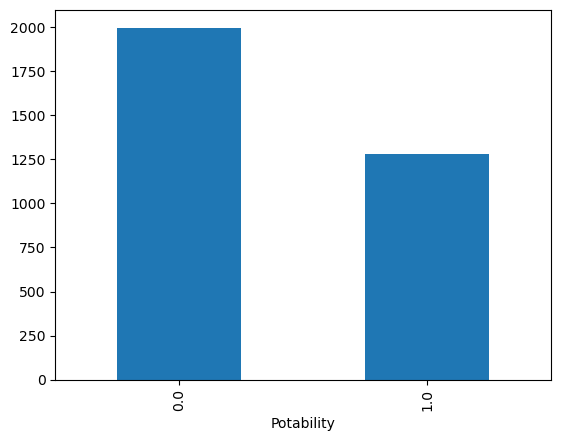

In [4]:
df_imputed['Potability'].value_counts().plot(kind='bar')

### Distribution of values for each characteristic.

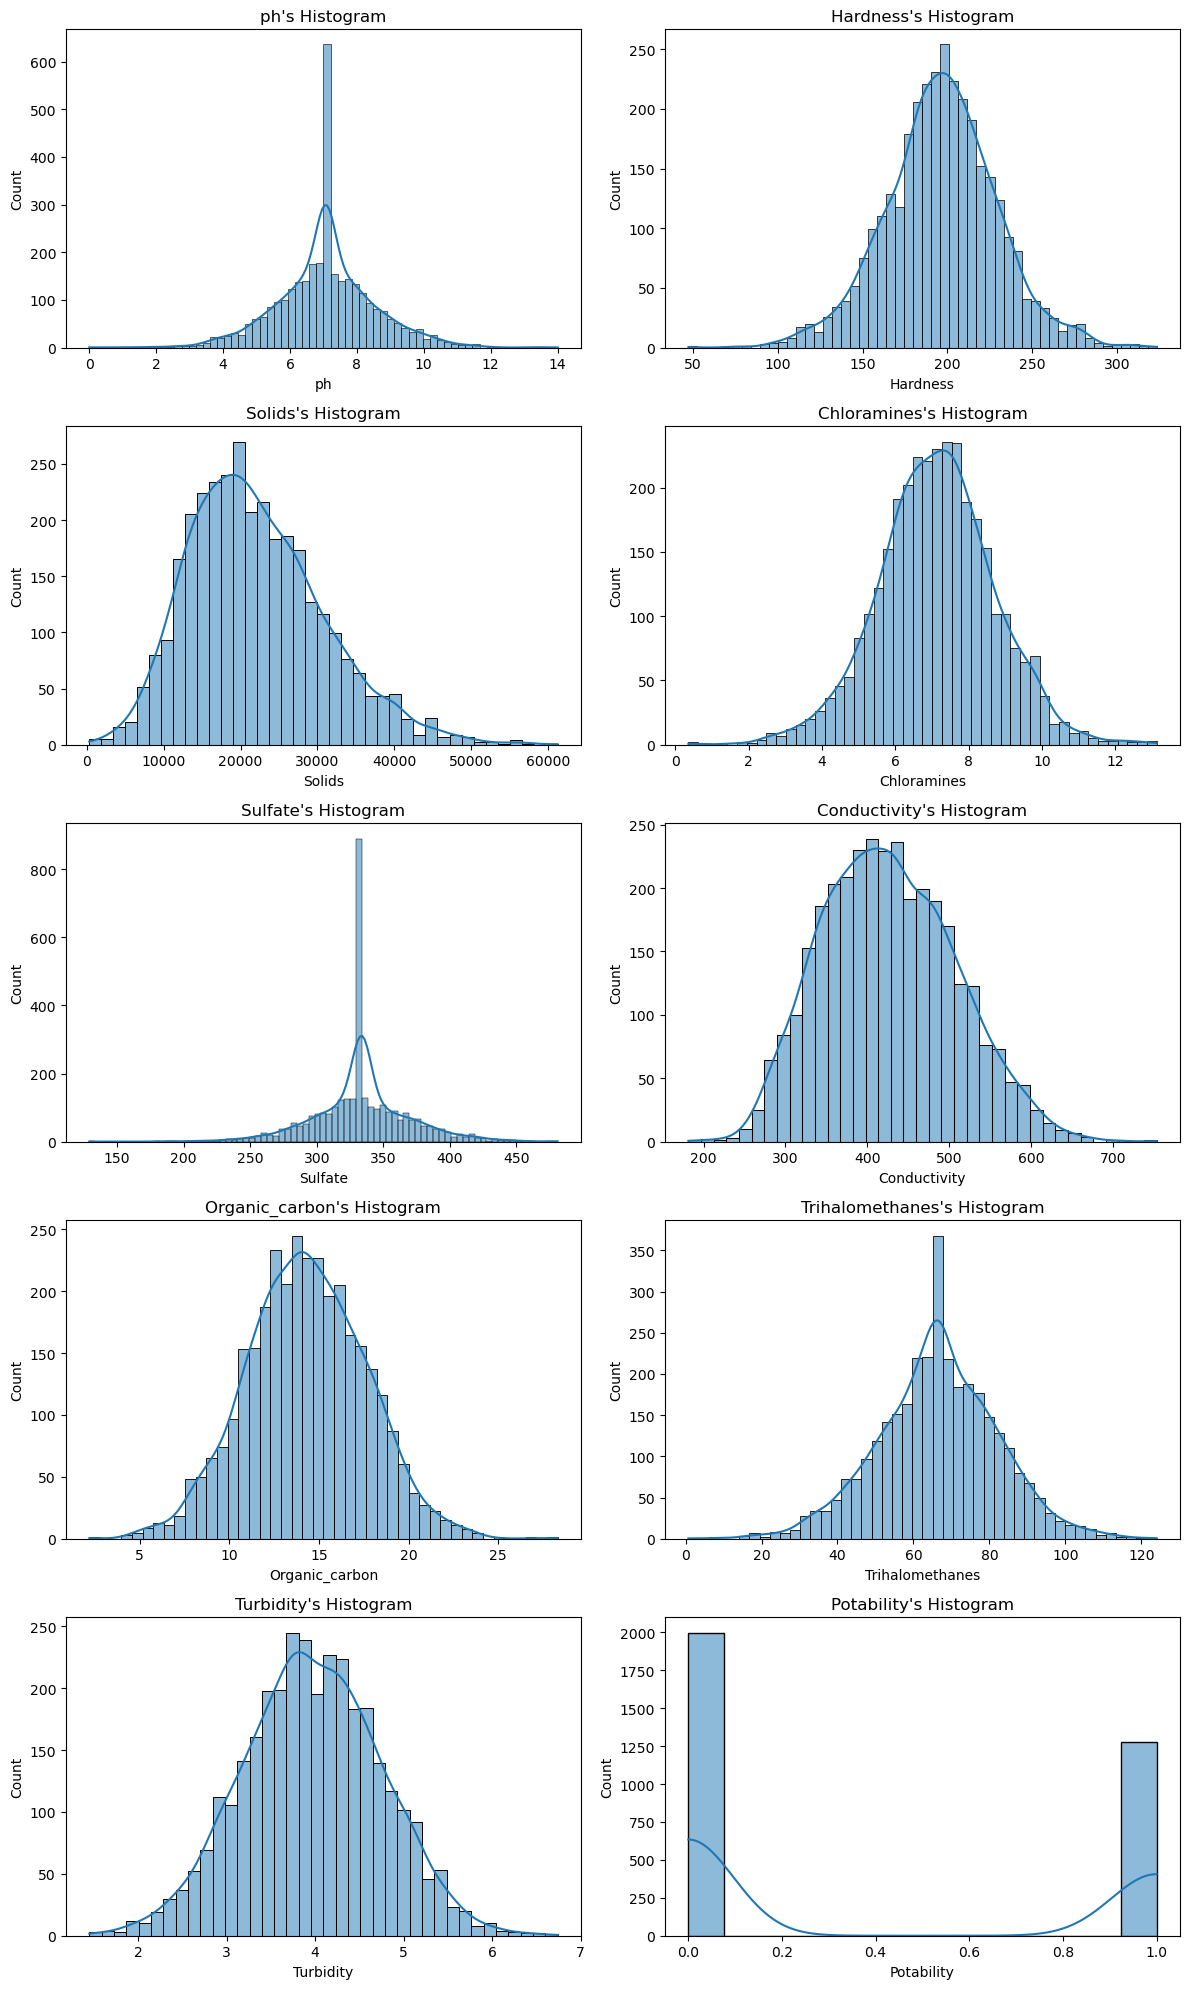

In [5]:
plt.figure(figsize=(12,20))

for n, column in enumerate(df_imputed.columns):
    plt.subplot(5, 2, n+1)
    sns.histplot(df_imputed[column], kde=True)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f"{column}'s Histogram")

plt.tight_layout()
plt.show()

### Outliers

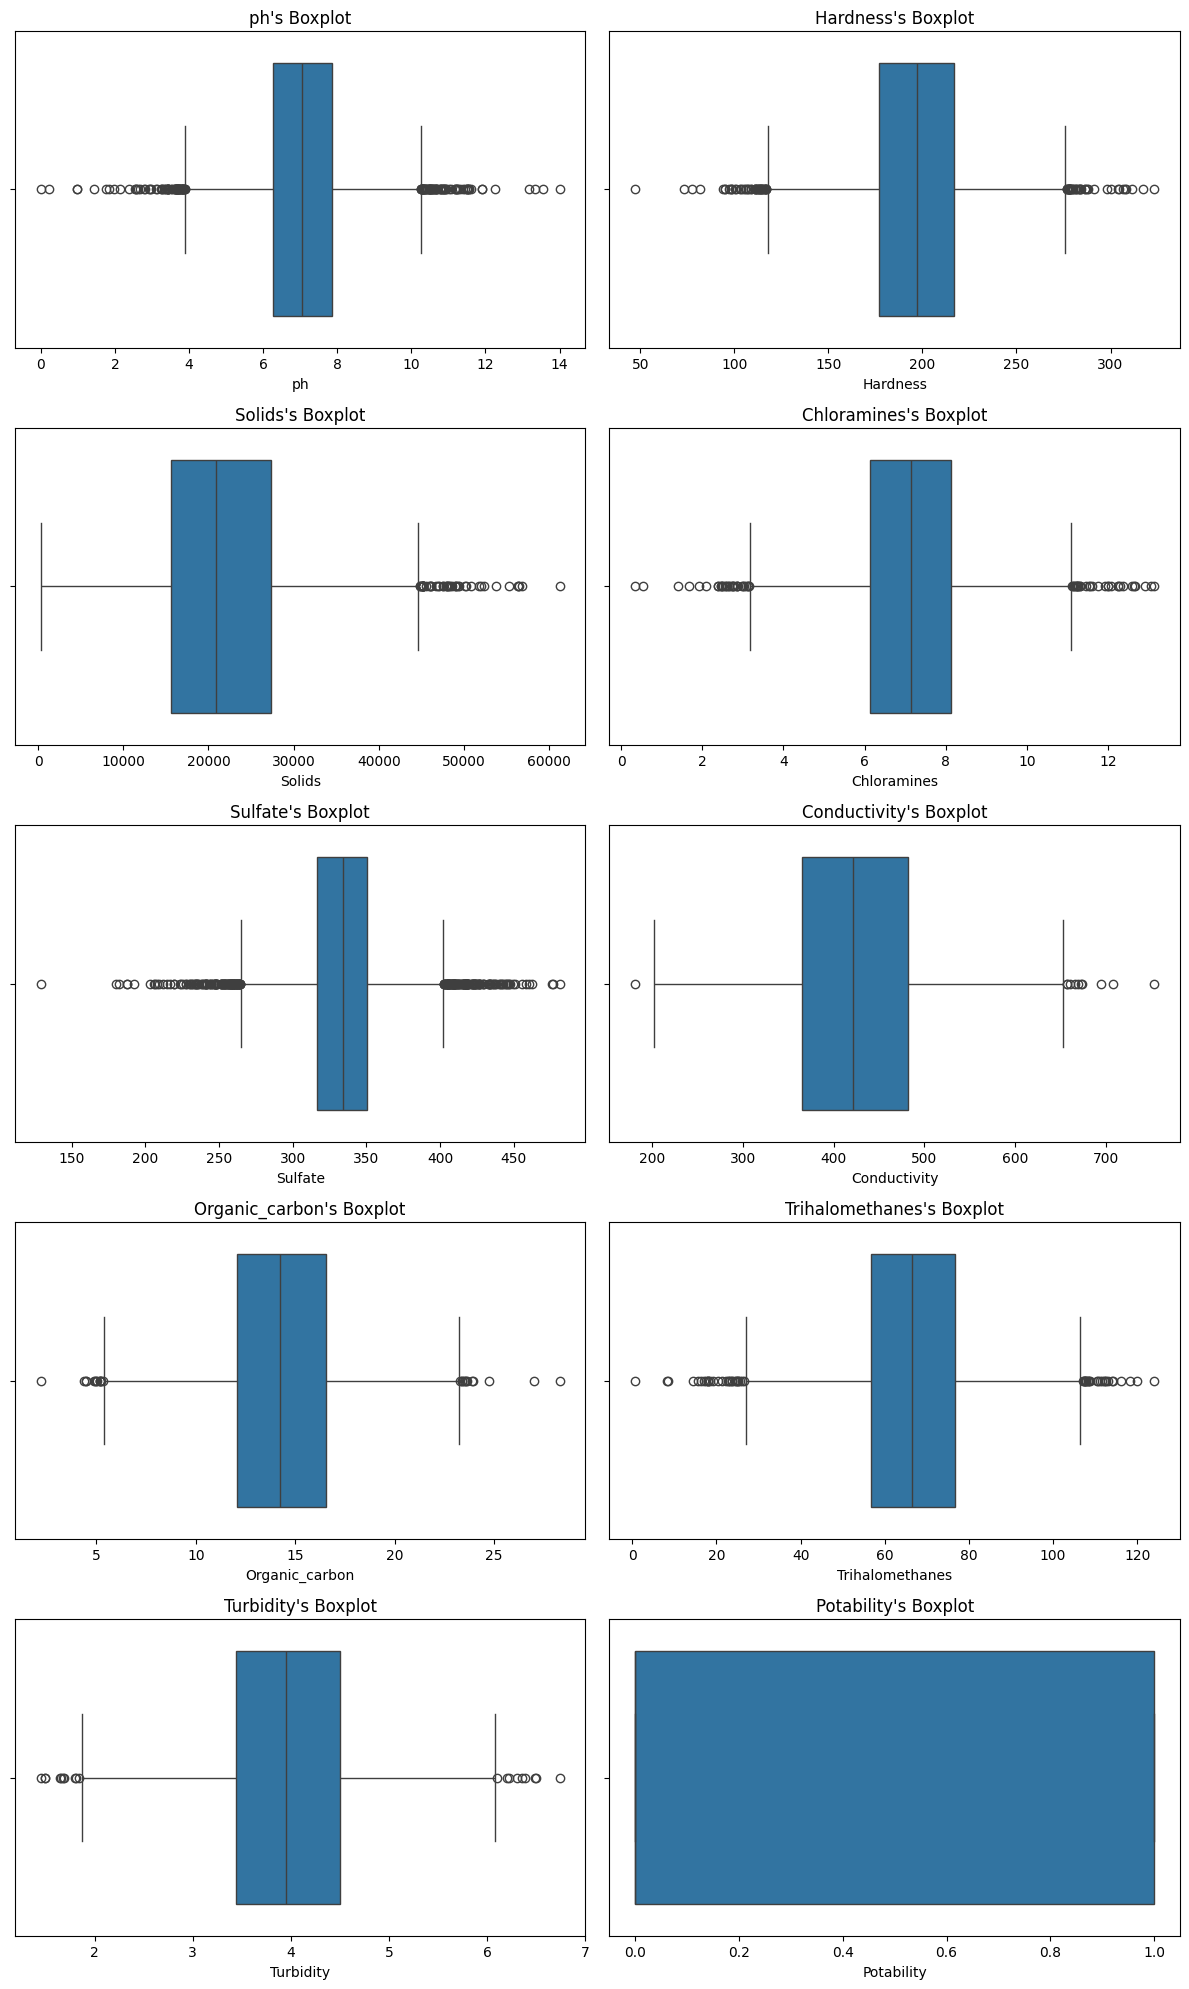

In [14]:
plt.figure(figsize=(12,20))

for n, column in enumerate(df_imputed.columns):
    plt.subplot(5, 2, n+1)
    sns.boxplot(x=df_imputed[column])
    plt.xlabel(column)
    plt.title(f"{column}'s Boxplot")

plt.tight_layout()
plt.show()

In [7]:
from sklearn.ensemble import IsolationForest

# Select only the numeric columns
numeric_columns = df_imputed.select_dtypes(include=['float64', 'int64'])

# Initialize and fit the Isolation Forest model
clf = IsolationForest(random_state=0)
clf.fit(numeric_columns)

# Identify outliers (1 for normal values, -1 for outliers)
outliers = clf.predict(numeric_columns)

# Filter only the normal (non-outlier) values
df_cleaned = df_imputed[outliers == 1]


### Normalization


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Select the numeric features
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the numeric features
numeric_columns_scaled = scaler.fit_transform(numeric_columns)

# Create a DataFrame with scaled features
df_scaled = pd.DataFrame(numeric_columns_scaled, columns=numeric_columns.columns)


### Data balancing

In [10]:
from imblearn.over_sampling import RandomOverSampler

# Select your features and the target variable
X = df_scaled.drop('Potability', axis=1)
y = df_scaled['Potability']

# Initialize the RandomOverSampler object
oversampler = RandomOverSampler(random_state=0)

# Apply oversampling to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)


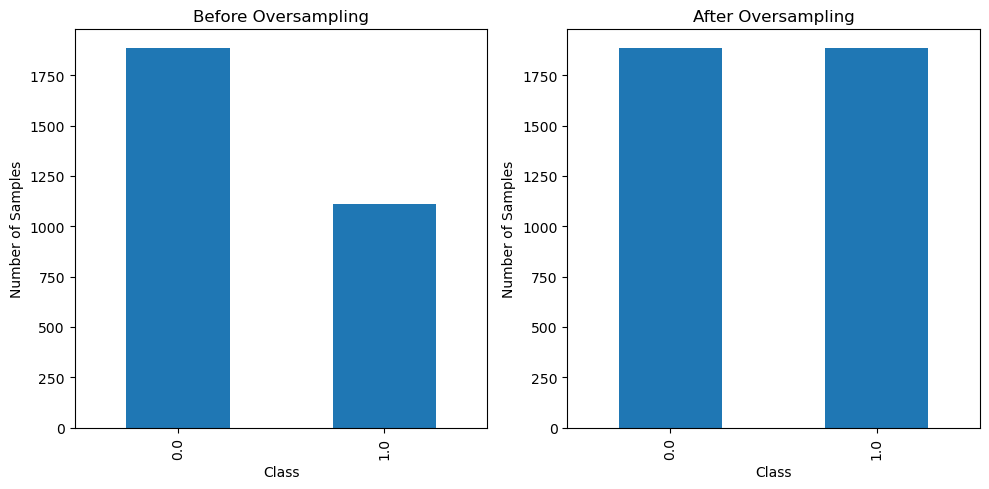

In [11]:
before_oversampling = y.value_counts()
after_oversampling = y_resampled.value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

before_oversampling.plot(kind='bar', ax=axs[0])
axs[0].set_title('Before Oversampling')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Samples')

after_oversampling.plot(kind='bar', ax=axs[1])
axs[1].set_title('After Oversampling')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Samples')

plt.tight_layout()

plt.show()



### Splitting of training and test data

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


X_train shape: (3014, 9)
X_test shape: (754, 9)


### Features importance

           feature  importance       std
0               ph    0.127395  0.018392
1         Hardness    0.122393  0.017325
4          Sulfate    0.115309  0.016348
3      Chloramines    0.114821  0.017601
2           Solids    0.114441  0.016521
6   Organic_carbon    0.105554  0.016581
5     Conductivity    0.102732  0.016001
8        Turbidity    0.099132  0.016055
7  Trihalomethanes    0.098223  0.016080


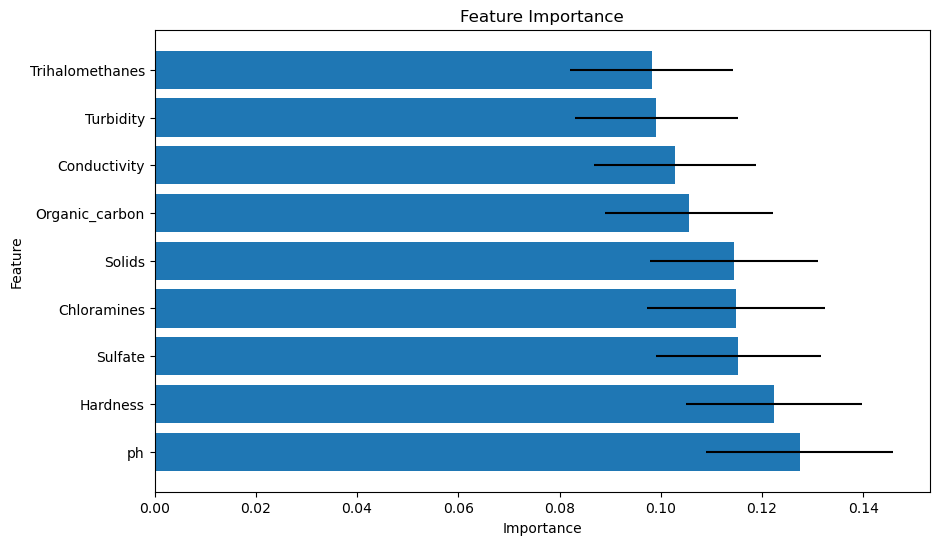

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=1000, random_state=2)

# Train the Random Forest classifier
rf.fit(X_train, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Get the standard deviation of feature importances across all trees
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create a DataFrame with features and their importances
df_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(df_importances['feature'], df_importances['importance'], xerr=df_importances['std'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Select features with importance greater than or equal to 0.05
select_features = df_importances[df_importances.importance >= 0.05].feature


# Modelado I

In [14]:
# Select models, fit data, and measure classification performance
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

LR = LogisticRegression()
LR.fit(X_train, y_train)

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

GNB = GaussianNB()
GNB.fit(X_train, y_train)

models = [KNN, LR, RF, GNB]

train_acc = []
test_acc = []
train_logloss = []
test_logloss = []
train_rocauc = []
test_rocauc = []

for model in models:
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)
    train_acc.append(round(accuracy_score(y_train, y_train_hat)*100, 2))
    test_acc.append(round(accuracy_score(y_test, y_test_hat)*100, 2))
    train_logloss.append(log_loss(y_train, y_train_hat))
    test_logloss.append(log_loss(y_test, y_test_hat))
    train_rocauc.append(round(roc_auc_score(y_train, y_train_hat), 2))
    test_rocauc.append(round(roc_auc_score(y_test, y_test_hat), 2))

# Create a DataFrame with performance metrics
metrics = pd.DataFrame({'Train Accuracy %': train_acc, 'Test Accuracy %': test_acc, 'Train Log Loss': train_logloss,
                       'Test Log Loss': test_logloss, 'Train ROC AUC': train_rocauc, 'Test ROC AUC': test_rocauc}, 
                   index=['K-Nearest Neighbor', 'Logistic Regression','Random Forest', 'Gaussian Naive Bayes'])

metrics

,Train Accuracy %,Test Accuracy %,Train Log Loss,Test Log Loss,Train ROC AUC,Test ROC AUC
K-Nearest Neighbor,76.31,62.33,8.538543e+00,13.576124,0.76,0.62
Logistic Regression,51.73,50.93,1.739997e+01,17.687204,0.52,0.51
Random Forest,100.00,79.31,2.220446e-16,7.457308,1.00,0.79
Gaussian Naive Bayes,56.50,55.44,1.567791e+01,16.061893,0.56,0.56


# Tuning de hiperparametros

In [15]:
# Specify hyperparameters for the grid
n_estimators = list(range(200, 2000, 200))
max_depth = list(range(10, 110, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

param_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [16]:
# Initialize and fit RandomizedSearchCV for Random Forest
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = param_grid, 
                               n_iter = 5, cv = 3, verbose=0, random_state=2000, n_jobs = -1)

# Fit RandomizedSearchCV to the training data
RF_random.fit(X_train, y_train)

# Print the best hyperparameters found
print(RF_random.best_params_)


{'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 90, 'bootstrap': False}


In [17]:
# Now, using the best parameters found in the random search, we'll compare its performance with the first model.

# Initialize Random Forest with best parameters
RF = RandomForestClassifier(n_estimators=1200, min_samples_split=5, min_samples_leaf=4, max_depth=50, bootstrap=True)
RF.fit(X_train, y_train)

# Predictions on train and test data
y_train_hat = RF.predict(X_train)
y_test_hat = RF.predict(X_test)

# Append performance metrics
train_acc.append(round(accuracy_score(y_train, y_train_hat)*100, 2))
test_acc.append(round(accuracy_score(y_test, y_test_hat)*100, 2))
train_logloss.append(log_loss(y_train, y_train_hat))
test_logloss.append(log_loss(y_test, y_test_hat))
train_rocauc.append(round(roc_auc_score(y_train, y_train_hat), 2))
test_rocauc.append(round(roc_auc_score(y_test, y_test_hat), 2))

# Create DataFrame with updated metrics
metrics = pd.DataFrame({'Train Accuracy %': train_acc, 'Test Accuracy %': test_acc, 'Train Log Loss': train_logloss,
                       'Test Log Loss': test_logloss, 'Train ROC AUC': train_rocauc, 'Test ROC AUC': test_rocauc}, 
                   index=['K-Nearest Neighbor', 'Logistic Regression','Random Forest', 'Gaussian Naive Bayes', 'Random Forest Tuned'])

metrics

,Train Accuracy %,Test Accuracy %,Train Log Loss,Test Log Loss,Train ROC AUC,Test ROC AUC
K-Nearest Neighbor,76.31,62.33,8.538543e+00,13.576124,0.76,0.62
Logistic Regression,51.73,50.93,1.739997e+01,17.687204,0.52,0.51
Random Forest,100.00,79.31,2.220446e-16,7.457308,1.00,0.79
Gaussian Naive Bayes,56.50,55.44,1.567791e+01,16.061893,0.56,0.56
Random Forest Tuned,99.40,77.59,2.152574e-01,8.078750,0.99,0.78
